<a href="https://colab.research.google.com/github/space-owner/Deep-Learning/blob/main/Multi%20Class%20Classification%20with%20Animals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Multi-Class Classification***

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from google.colab.patches import cv2_imshow

In [ ]:
search_dir = "data/animals"

image_paths = sorted(
    list(paths.list_images(search_dir))
)

print(">>> image count =", len(image_paths))

>>> image count = 3000


In [ ]:
image_dim = (96, 96, 3)

images = []
labels = []
for image_path in tqdm(image_paths):
    image = cv2.imread(image_path)

    image = cv2.resize(
        image, (image_dim[1], image_dim[0])
    )
    images.append(image)
    
    label = image_path.split(os.path.sep)[-2]
    labels.append([label])

images = np.array(images, dtype='float') / 255.0

labels = np.array(labels)

print(">>> images count =", len(images))

100%|██████████| 3000/3000 [28:22<00:00,  1.76it/s]


>>> images count = 3000


In [ ]:
mlb = MultiLabelBinarizer()

enc_labels = mlb.fit_transform(labels)

print(">>> classes name =", mlb.classes_)

>>> classes name = ['cats' 'dogs' 'panda']


In [ ]:
seed = 47

(x_train, x_test, y_train, y_test) = train_test_split(
    images, enc_labels, test_size=0.2, random_state=seed
)
print(">> train test shape = {} {}".format(
    x_train.shape, y_train.shape)
)

>> train test shape = (2400, 96, 96, 3) (2400, 3)


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)

In [ ]:
class Classifier:
	def build(width, height, depth, classes):
		model = Sequential()
		input_shape = (height, width, depth)
		channel_dim = -1
		
		model.add(
            Conv2D(32, (3, 3), padding='same', input_shape=input_shape)
        )
		model.add(
            Activation('relu')
        )
		model.add(
            BatchNormalization(axis=channel_dim)
        )
		model.add(
            MaxPooling2D(pool_size=(3, 3))
        )
		model.add(
            Dropout(0.25)
        )
  
		model.add(
            Conv2D(64, (3, 3), padding='same')
        )
		model.add(
            Activation('relu')
        )
		model.add(
            BatchNormalization(axis=channel_dim)
        )
		model.add(
            Conv2D(64, (3, 3), padding='same')
        )
		model.add(
            Activation('relu')
        )
		model.add(
            BatchNormalization(axis=channel_dim)
        )
		model.add(
            MaxPooling2D(pool_size=(2, 2))
        )
		model.add(
            Dropout(0.25)
        )
 
		model.add(
            Conv2D(128, (3, 3), padding='same')
        )
		model.add(
            Activation('relu')
        )
		model.add(
            BatchNormalization(axis=channel_dim)
        )
		model.add(
            Conv2D(128, (3, 3), padding='same')
        )
		model.add(
            Activation('relu')
        )
		model.add(
            BatchNormalization(axis=channel_dim)
        )
		model.add(
            MaxPooling2D(pool_size=(2, 2))
        )
		model.add(
            Dropout(0.25)
        )

		model.add(
            Conv2D(256, (3, 3), padding='same')
        )
		model.add(
            Activation('relu')
        )
		model.add(
            BatchNormalization(axis=channel_dim)
        )
		model.add(
            Conv2D(256, (3, 3), padding='same')
        )
		model.add(
            Activation('relu')
        )
		model.add(
            BatchNormalization(axis=channel_dim)
        )
		model.add(
            MaxPooling2D(pool_size=(2, 2))
        )
		model.add(
            Dropout(0.25)
        )

		model.add(
            Flatten()
        )
		model.add(
            Dense(2048)
        )
		model.add(
            Activation('relu')
        )
		model.add(
            BatchNormalization()
        )
		model.add(
            Dropout(0.5)
        )
  
		model.add(
            Dense(classes)
        )
		model.add(
            Activation('softmax')
        )
		return model

model = Classifier.build(
    width=image_dim[1], height=image_dim[0], depth=image_dim[2],
    classes=len(mlb.classes_)
)

In [ ]:
batch_size = 32
epoch = 200
learning_rate = 1e-3
decay = learning_rate / epoch

optimizer = Adam(
    learning_rate=learning_rate,
    decay=decay
)

loss = CategoricalCrossentropy(from_logits=False)

model.compile(
    loss=loss,
    optimizer=optimizer,
	metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0

In [ ]:
# early_stopping = EarlyStopping(
#     monitor='val_loss', mode='min', verbose=1, patience=50
# )

# check_point = ModelCheckpoint(
#     'best_model.h5', monitor='val_loss', mode='min', save_best_only=True
# )

history = model.fit_generator(
	aug.flow(
        x_train, y_train, batch_size=batch_size
    ),
	validation_data=(x_test, y_test),
	steps_per_epoch=len(x_train) // batch_size,
	epochs=epoch, verbose=1,
    # callbacks=[early_stopping, model_check]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
75/75 [==============================] - 40s 113ms/step - loss: 1.5247 - accuracy: 0.5562 - val_loss: 3.1929 - val_accuracy: 0.3150
Epoch 2/200
75/75 [==============================] - 8s 102ms/step - loss: 0.9905 - accuracy: 0.6021 - val_loss: 1.8746 - val_accuracy: 0.3500
Epoch 3/200
75/75 [==============================] - 8s 102ms/step - loss: 0.9192 - accuracy: 0.6221 - val_loss: 3.2068 - val_accuracy: 0.3500
Epoch 4/200
75/75 [==============================] - 8s 102ms/step - loss: 0.8743 - accuracy: 0.6292 - val_loss: 1.3691 - val_accuracy: 0.3967
Epoch 5/200
75/75 [==============================] - 8s 102ms/step - loss: 0.7978 - accuracy: 0.6508 - val_loss: 1.2389 - val_accuracy: 0.4250
Epoch 6/200
75/75 [==============================] - 8s 102ms/step - loss: 0.7651 - accuracy: 0.6629 - val_loss: 2.1172 - val_accuracy: 0.4283
Epoch 7/200
75/75 [==============================] - 8s 103ms/step - loss: 0.7412 - accuracy: 0.6696 - val_loss: 0.7568 - val_accuracy: 0.678

In [ ]:
# early_stopping = EarlyStopping(
#     monitor='val_loss', mode='min', verbose=1, patience=50
# )

# check_point = ModelCheckpoint(
#     'best_model.h5', monitor='val_loss', mode='min', save_best_only=True
# )

history = model.fit_generator(
	aug.flow(
        x_train, y_train, batch_size=batch_size
    ),
	validation_data=(x_test, y_test),
	steps_per_epoch=len(x_train) // batch_size,
	epochs=epoch, verbose=1,
    # callbacks=[early_stopping, model_check]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
75/75 [==============================] - 20s 113ms/step - loss: 1.5992 - accuracy: 0.5308 - val_loss: 6.0903 - val_accuracy: 0.3500
Epoch 2/100
75/75 [==============================] - 8s 104ms/step - loss: 1.0309 - accuracy: 0.5938 - val_loss: 4.1035 - val_accuracy: 0.3500
Epoch 3/100
75/75 [==============================] - 8s 103ms/step - loss: 0.8922 - accuracy: 0.6029 - val_loss: 2.9137 - val_accuracy: 0.3500
Epoch 4/100
75/75 [==============================] - 8s 106ms/step - loss: 0.8795 - accuracy: 0.6442 - val_loss: 3.1884 - val_accuracy: 0.3883
Epoch 5/100
75/75 [==============================] - 8s 107ms/step - loss: 0.8429 - accuracy: 0.6375 - val_loss: 1.2580 - val_accuracy: 0.4667
Epoch 6/100
75/75 [==============================] - 8s 105ms/step - loss: 0.7681 - accuracy: 0.6475 - val_loss: 0.7564 - val_accuracy: 0.6367
Epoch 7/100
75/75 [==============================] - 8s 105ms/step - loss: 0.7355 - accuracy: 0.6675 - val_loss: 0.7703 - val_accuracy: 0.640

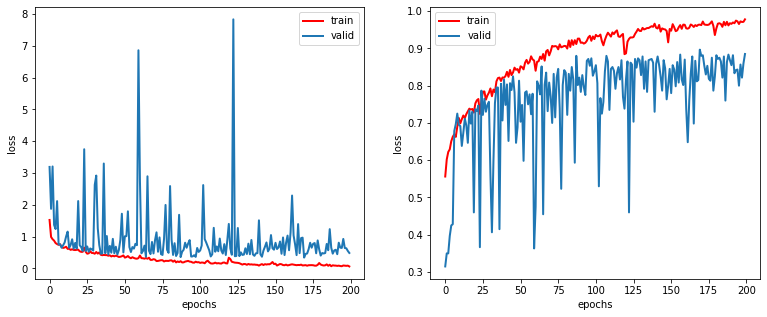

In [ ]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(13, 5)

ax1.plot(np.arange(0, len(history.history['loss'])), history.history['loss'], label="train", linestyle="-", linewidth=2.0, color='red')
ax1.plot(np.arange(0, len(history.history['loss'])), history.history['val_loss'], label="valid", linestyle="-", linewidth=2.0)
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.legend(loc="upper right")

ax2.plot(np.arange(0, len(history.history['loss'])), history.history['accuracy'], label="train", linestyle="-", linewidth=2.0, color='red')
ax2.plot(np.arange(0, len(history.history['loss'])), history.history['val_accuracy'], label="valid", linestyle="-", linewidth=2.0)
ax2.set_xlabel("epochs")
ax2.set_ylabel("loss")
ax2.legend(loc="upper left")
plt.show()

In [ ]:
test_image_paths = sorted(
    list(
        paths.list_images("data/images")
    )
)
print(">>> test image path =", test_image_paths)

>>> test image path = ['data/images/cat.jpg', 'data/images/dog.jpg', 'data/images/panda.jpg']


>>> class index = ['cats' 'dogs' 'panda']


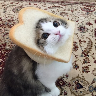

[0.091 0.875 0.034]
>>> predict class = dogs


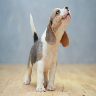

[0.001 0.999 0.   ]
>>> predict class = dogs


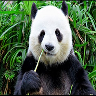

[0. 0. 1.]
>>> predict class = panda


In [ ]:
print(">>> class index =",  mlb.classes_)

for image_path in test_image_paths:
    test_image = cv2.imread(image_path)

    test_image = cv2.resize(
        test_image, (96, 96)
    )
    cv2_imshow(test_image)

    test_image = test_image.astype("float") / 255.0
    test_image = np.expand_dims(test_image, axis=0)

    proba = model.predict(test_image)[0]
    print(
        np.round(proba, 3)
    )
    idx = np.argmax(proba)
    print(">>> predict class =", mlb.classes_[idx])